In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')

# os.chdir('/content/drive/MyDrive/ProyectoFinal/Proyecto1JFCL')
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content


In [3]:
from skimage.transform import resize
import time
import numpy as np
from numpy import save
from numpy import load
import pandas as pd
import matplotlib as plt
import imutils
import dlib
import cv2
import imageio
from imutils import face_utils
from keras.utils import np_utils, generic_utils
from sklearn.utils import shuffle

In [4]:
people = ['F01','F02','F04','F05','F06','F07','F08','F09', 'F10','F11','M01','M02','M04','M07','M08']
data_types = ['words']
folder_enum = ['01','02','03','04','05','06','07','08', '09', '10']
instances = ['01','02','03','04','05','06','07','08', '09', '10']

words = ['Begin', 'Choose', 'Connection', 'Navigation', 'Next', 'Previous', 'Start', 'Stop', 'Hello', 'Web']          
words_di = {i:words[i] for i in range(len(words))}

In [7]:
!ls data

X_test.npy  X_train.npy  X_val.npy  y_test.npy	y_train.npy  y_val.npy


In [8]:
#@title Make _op_flow_lk.npy file to load data esasily
max_seq_length = 22

X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test = []


MAX_WIDTH = 100
MAX_HEIGHT = 100
t1 = time.time()
UNSEEN_VALIDATION_SPLIT = ['F07', 'M02']
UNSEEN_TEST_SPLIT = ['F04']

directory = "../data/opt_flow"

for person_id in people:
  tx1 = time.time()
  for data_type in data_types:
    for word_index, word in enumerate(folder_enum):
#             print(f"Word : '{words[word_index]}'")
      for iteration in instances:
        path = os.path.join(directory, person_id, data_type, word, iteration)
        hola=os.path.exists(path)
        if hola:
          filelist = sorted(os.listdir(path + '/'))
          sequence = [] 
          for img_name in filelist:
            if img_name.startswith('color'):
              image = imageio.imread(path + '/' + img_name)
              image = resize(image, (MAX_WIDTH, MAX_HEIGHT))
              image = 255 * image
              # Convert to integer data type pixels.
              image = image.astype(np.uint8)
              sequence.append(image)                        
          pad_array = [np.zeros((MAX_WIDTH, MAX_HEIGHT))]                            
          sequence.extend(pad_array * (max_seq_length - len(sequence)))
          sequence = np.array(sequence)

          if person_id in UNSEEN_TEST_SPLIT:
            X_test.append(sequence)
            y_test.append(word_index)
          elif person_id in UNSEEN_VALIDATION_SPLIT:
            X_val.append(sequence)
            y_val.append(word_index)
          else:
            X_train.append(sequence)
            y_train.append(word_index)
        else:
          print("No existe",path)
  tx2 = time.time()
  print(f'Finished reading images for person {person_id}. Time taken : {tx2 - tx1} secs.')    
    
t2 = time.time()
print(f"Time taken for creating constant size 3D Tensors from those cropped lip regions : {t2 - t1} secs.")

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

np.save('/content/drive/My Drive/ProyectoFinal/X_train_op_flow_lk.npy',X_train)
np.save('/content/drive/My Drive/ProyectoFinal/X_val_op_flow_lk.npy',X_val)
np.save('/content/drive/My Drive/ProyectoFinal/X_test_op_flow_lk.npy',X_test)
np.save('/content/drive/My Drive/ProyectoFinal/y_train_op_flow_lk.npy',y_train)
np.save('/content/drive/My Drive/ProyectoFinal/y_val_op_flow_lk.npy',y_val)
np.save('/content/drive/My Drive/ProyectoFinal/y_test_op_flow_lk.npy',y_test)

Finished reading images for person F01. Time taken : 22.49975347518921 secs.
Finished reading images for person F02. Time taken : 29.109620094299316 secs.
Finished reading images for person F04. Time taken : 32.562198877334595 secs.
Finished reading images for person F05. Time taken : 26.485626697540283 secs.
Finished reading images for person F06. Time taken : 22.29083228111267 secs.
Finished reading images for person F07. Time taken : 27.758355379104614 secs.
Finished reading images for person F08. Time taken : 30.527220249176025 secs.
Finished reading images for person F09. Time taken : 24.635876178741455 secs.
Finished reading images for person F10. Time taken : 22.782074689865112 secs.
Finished reading images for person F11. Time taken : 22.835457801818848 secs.
Finished reading images for person M01. Time taken : 25.831619262695312 secs.
Finished reading images for person M02. Time taken : 27.618054628372192 secs.
Finished reading images for person M04. Time taken : 32.3679866790

In [5]:
X_train=np.load('/content/drive/My Drive/ProyectoFinal/Proyecto1JFCL/data/X_train_op_flow_lk.npy')
X_val=np.load('/content/drive/My Drive/ProyectoFinal/Proyecto1JFCL/data/X_val_op_flow_lk.npy')
X_test=np.load('/content/drive/My Drive/ProyectoFinal/Proyecto1JFCL/data/X_test_op_flow_lk.npy')
y_train=np.load('/content/drive/My Drive/ProyectoFinal/Proyecto1JFCL/data/y_train_op_flow_lk.npy')
y_val=np.load('/content/drive/My Drive/ProyectoFinal/Proyecto1JFCL/data/y_val_op_flow_lk.npy')
y_test=np.load('/content/drive/My Drive/ProyectoFinal/Proyecto1JFCL/data/y_test_op_flow_lk.npy')

### Normalizacion y completamiento de los datos

In [6]:
def normalize_it(X):
  v_min = X.min(axis=(2, 3), keepdims=True)
  v_max = X.max(axis=(2, 3), keepdims=True)
  X = (X - v_min)/(v_max - v_min)
  X = np.nan_to_num(X)
  return X

In [7]:
X_train = normalize_it(X_train)
X_val = normalize_it(X_val)
X_test = normalize_it(X_test)

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)
y_val = np_utils.to_categorical(y_val, 10)

X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)
X_val, y_val = shuffle(X_val, y_val, random_state=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [8]:
X_train = np.expand_dims(X_train, axis=4)
X_val = np.expand_dims(X_val, axis=4)
X_test = np.expand_dims(X_test, axis=4)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(1200, 22, 100, 100, 1)
(200, 22, 100, 100, 1)
(100, 22, 100, 100, 1)


### Modelo

In [9]:
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.layers.core import Dense, Dropout, Flatten
from keras.models import Sequential
from keras.layers import Activation, ZeroPadding3D, TimeDistributed, LSTM, GRU, Reshape
from keras.utils import plot_model
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from tensorflow.keras.backend import clear_session

import matplotlib.pyplot as plt

In [ ]:
#del model
#del history

In [17]:
clear_session()
model = Sequential()

# 1st layer group
model.add(Conv3D(64, (3, 3, 3), strides = 1, input_shape=(22, 100, 100, 1), activation='relu', padding='valid'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))

model.add(Conv3D(128, (3, 3, 3), activation='relu', strides=1))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))

model.add(Conv3D(256, (2, 2, 2), activation='relu', strides=1))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))

model.add((Flatten()))

# # FC layers group
model.add(Dense(4096, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(.5))

model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adagrad', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 98, 98, 64)    1792      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 49, 49, 64)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 47, 47, 128)    221312    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 4, 23, 23, 128)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 3, 22, 22, 256)    262400    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 1, 11, 11, 256)    0         
_________________________________________________________________
flatten (Flatten)            (None, 30976)             0


Training time : 3389.948689222336 secs.


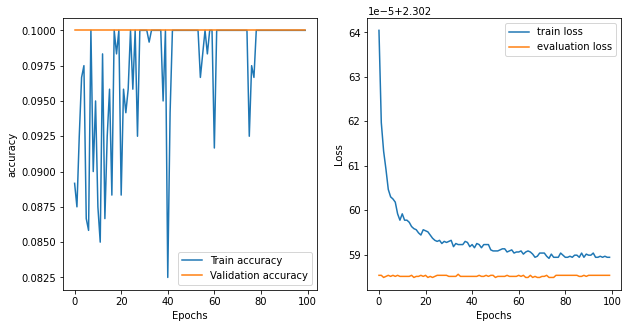

In [18]:
#@title Code training
t1 = time.time()
# model.compile(loss='categorical_crossentropy', optimizer='Adagrad', metrics=['accuracy'])
# model.summary()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16,epochs=100, verbose=0)
t2 = time.time()
print()
print(f"Training time : {t2 - t1} secs.")
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['accuracy'], label='Train accuracy');
ax.plot(history.history['val_accuracy'], label='Validation accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label='train loss');
ax.plot(history.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

### Predicción de modelos

In [ ]:
ypred = model.predict(X_test)

predicted_words = [words[i] for i in np.argmax(ypred, axis=1)]
actual_words = [words[i] for i in np.argmax(y_test, axis=1)] 

correct = 0
for p, a in zip(predicted_words, actual_words):
    if p == a:
        correct += 1
#     print(f"Predicted : {p} \t Actual : {a}")

accuracy = correct/len(actual_words)
print(f"Accuracy = {accuracy} on completely unseen data")

Accuracy = 0.2 on completely unseen data
